## Board game recommendation engine 

#### John Burt


#### purpose of this notebook:

Explore Alternating Least Squares Method for collaborative filtering

Code and ideas from:
https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/


## load data from csv file

- Set up plot environment.
- boardgame rating data from csv into pandas dataframe


In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

# load the boardgame user data
#userdata = pd.read_csv('boardgame-users.csv')
#userdata = pd.read_csv('boardgame-elite-users.csv')
userdata = pd.read_csv('boardgame-frequent-users.csv')


# rename the userID column
userdata=userdata.rename(columns = {"Compiled from boardgamegeek.com by Matt Borthwick":'userID'})

# load the boardgame title data
titledata = pd.read_csv('boardgame-titles.csv')

# rename the gameID column
titledata=titledata.rename(columns = {"boardgamegeek.com game ID":'gameID'})

# for titledata set game ID as the index
titledata = titledata.set_index("gameID")

#print(userdata.head())
#print("\n", titledata.head())


Pivot user rating data, creating users (row) x gameID (col) x rating

In [3]:
# pivot the user data to create rows of users, with columns games. 
# If a user rated a game, it will be at user x game and if not, then the cell will be NAN
#rp = userdata.pivot(index="userID", columns="gameID", values="rating")
rp = userdata.pivot(index="gameID", columns="userID", values="rating")
#rp.head()

Prep data for ALS

In [4]:
rp = rp.fillna(0); # Replace NaN w/ 0s

Q = rp.values

W = Q>0.5
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)
#W

Set parameters for the ALS algorithm

NoteS: 

n_factors = 100 seems to generate the best scattering of points at higher dimensions.
n_iterations = 10 seems best - actually usually flattens after only around 5 iterations

In [5]:
lambda_ = 0.1
n_factors = 100
m, n = Q.shape
n_iterations = 10

X = 5 * np.random.rand(m, n_factors) 
Y = 5 * np.random.rand(n_factors, n)

In [6]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

The ALS loop.

Note: this can take a while to complete

iteration 0, error = 456004.13
iteration 2, error = 234818.71
iteration 4, error = 203885.06
iteration 6, error = 190862.32
iteration 8, error = 183627.28
iteration 9, error = 181091.69


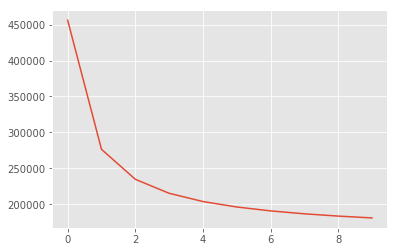

In [7]:
weighted_errors = []
for ii in range(n_iterations):
    for u, Wu in enumerate(W):
        X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
                               np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    for i, Wi in enumerate(W.T):
        Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
    if ii % 2 == 0:
        print("iteration %d, error = %4.2f"%(ii,get_error(Q, X, Y, W)))
    weighted_errors.append(get_error(Q, X, Y, W))

print("iteration %d, error = %4.2f"%(ii,get_error(Q, X, Y, W)))
weighted_Q_hat = np.dot(X,Y)

plt.plot(weighted_errors);

Here, you can try alternate methods to ALS of dealing with cells with no ratings, and do a standard transformation.

Standardization doesn't seem to improve the cluster results and may make it worse.

In [24]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# replace NaNs (unrated games) with zeros
#ratings2 = rp.fillna(0)

# replace NaNs (unrated games) with game's mean rating
#ratings2 = Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(rp)

#ratings_std = StandardScaler().fit_transform(weighted_Q_hat)
#ratings_std = StandardScaler().fit_transform(ratings2)
ratings_std = weighted_Q_hat

ratings_std.shape

(402, 2473)

Do the PCA / SVD 

In [25]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, TruncatedSVD, NMF
import scipy.sparse as sp

# number of dimensions for analysis
numdims = 4

coords = TruncatedSVD(n_components=numdims).fit_transform(ratings_std)

# some other methods:
#coords = PCA(n_components=numdims).fit_transform(ratings_std)
#coords = SparsePCA(n_components=numdims).fit_transform(ratings_std) # note: SparsePCA freezes
#coords = KernelPCA(n_components=numdims).fit_transform(ratings_std)
#coords = NMF(n_components=numdims).fit_transform(ratings_std)


Plot the resulting PCA / SVD output 

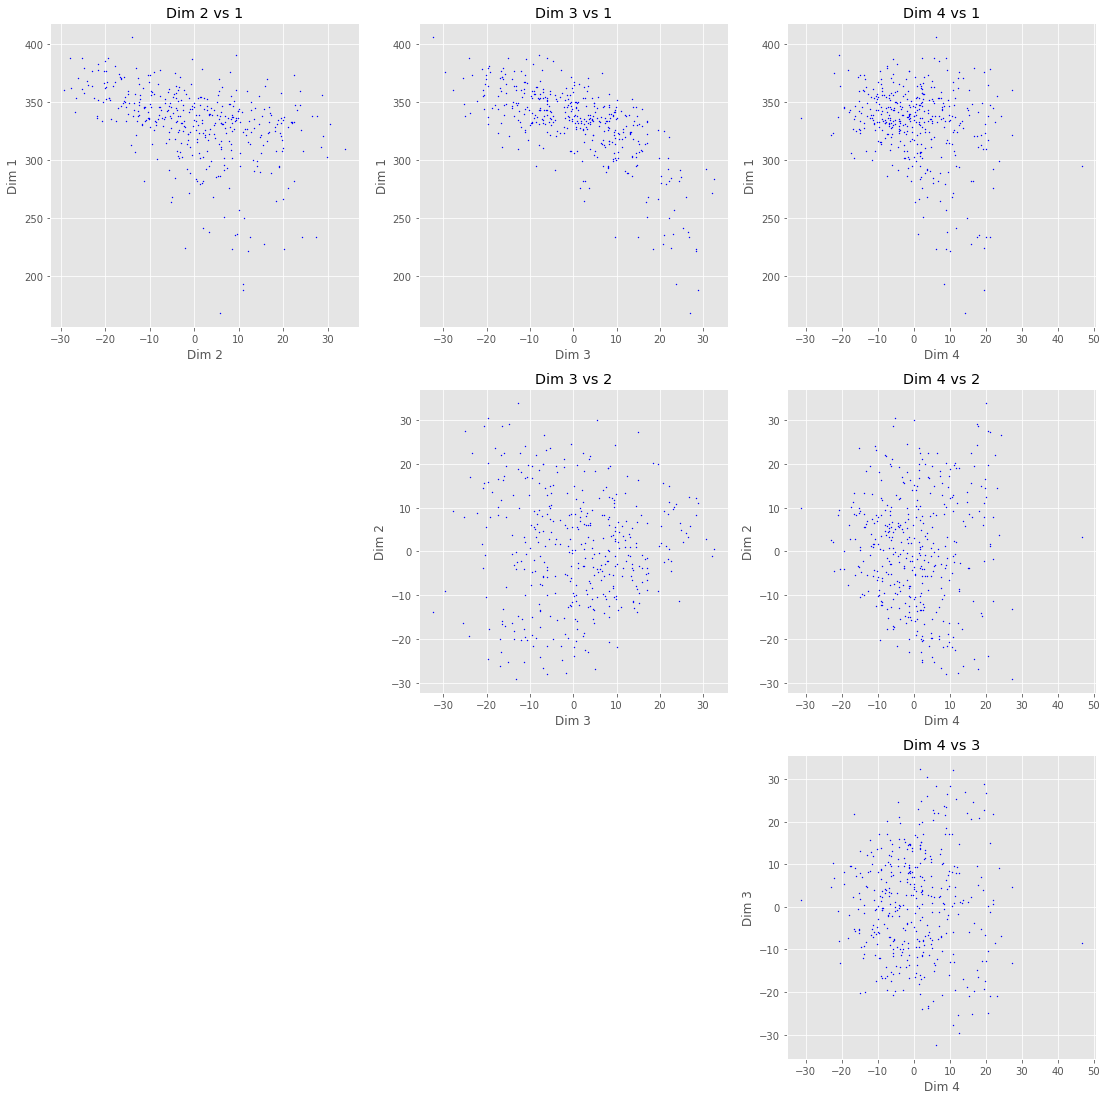

In [26]:
numdims = coords.shape[1]

plt.figure(figsize=(20, 20))
s = 2
axrange = 30

numrows = numdims
for i in range(numrows):
    for j in range(i+1):
        if i != j:
            plotnum = j*(numrows)+i+1
            plt.subplot(numrows, numrows, plotnum)
            sa = plt.scatter(coords[:,i],coords[:,j], color='b', s=s, lw=0, label='PCA')
            ta = plt.title("Dim %d vs %d"%(i+1,j+1))
            xl = plt.xlabel("Dim %d"%(i+1))
            yl = plt.ylabel("Dim %d"%(j+1))
            #plt.xlim([-axrange,axrange])
            #plt.ylim([-axrange,axrange])
            plt.tight_layout()

In [30]:
# func to plot one set of dimensions
def plot_cluster_map(coords, cluster_labels, symbols=[], centroids=[None], show_symbols=False):

    # #############################################################################
    # Visualization
    #plt.figure(1, facecolor='w', figsize=(15, 10))
    #plt.clf()
    #ax = plt.axes([0., 0., 1., 1.])
    #plt.axis('off')
    
    # Plot the nodes 
    plt.scatter(coords[:,0], coords[:,1], s=5, c=cluster_labels, cmap=plt.cm.spectral)
    
    # plot centroids, if they were passed
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", 
                    s=100, linewidths = 5, zorder = 10)

    # Add a stock symbol label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    if symbols and show_symbols:
        for index, (symbol, label, (x, y)) in enumerate(
                zip(symbols, cluster_labels, coords)):

            dx = x - coords[:,0]
            dx[index] = 1
            dy = y - coords[:,1]
            dy[index] = 1
            this_dx = dx[np.argmin(np.abs(dy))]
            this_dy = dy[np.argmin(np.abs(dx))]
            if this_dx > 0:
                horizontalalignment = 'left'
                x = x + .002
            else:
                horizontalalignment = 'right'
                x = x - .002
            if this_dy > 0:
                verticalalignment = 'bottom'
                y = y + .002
            else:
                verticalalignment = 'top'
                y = y - .002
            #plt.text(x, y, name, size=10,
            plt.text(x, y, symbol, size=15,
                     horizontalalignment=horizontalalignment,
                     verticalalignment=verticalalignment,
                     bbox=dict(facecolor='w',
                     #          edgecolor=plt.cm.spectral(label / float(n_labels)),
                               edgecolor='w',
                               alpha=.6)
                    )

    plt.xlim(coords[:,0].min() - .05 * coords[:,0].ptp(),
             coords[:,0].max() + .05 * coords[:,0].ptp(),)
    plt.ylim(coords[:,1].min() - .03 * coords[:,1].ptp(),
             coords[:,1].max() + .03 * coords[:,1].ptp())


In [31]:
from sklearn.cluster import KMeans

numclusters = 8

# cluster 
kmeans = KMeans(n_clusters=numclusters).fit(coords)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

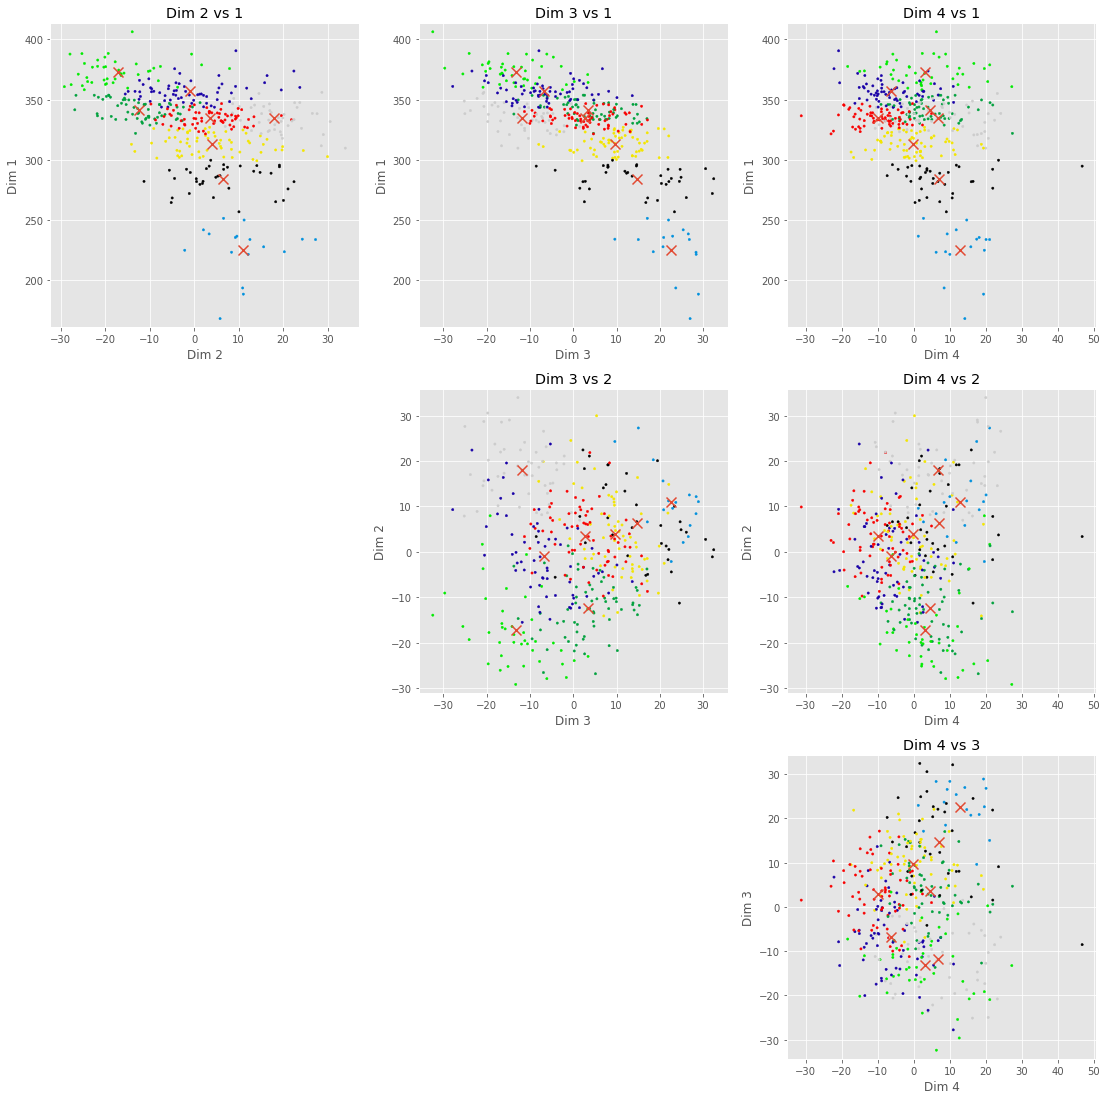

In [32]:
numdims = coords.shape[1]

plt.figure(figsize=(20, 20))
s = 2
axrange = 30

numrows = numdims
for i in range(numrows):
    for j in range(i+1):
        if i != j:
            plotnum = j*(numrows)+i+1
            plt.subplot(numrows, numrows, plotnum)
            plot_cluster_map(coords[:,[i,j]], labels, symbols=[], centroids=centroids[:,[i,j]])
            ta = plt.title("Dim %d vs %d"%(i+1,j+1))
            xl = plt.xlabel("Dim %d"%(i+1))
            yl = plt.ylabel("Dim %d"%(j+1))
            #plt.xlim([-axrange,axrange])
            #plt.ylim([-axrange,axrange])
            plt.tight_layout()

show contents of each cluster

In [23]:
names = titledata.title[rp.index].values

n_labels = np.unique(labels).shape[0]

for i in range(n_labels):
    print('Cluster %i: contains %d games: %s\n' % 
          ((i + 1), len((names[labels == i])), ', '.join(names[labels == i])))

Cluster 1: contains 38 games: Tigris & Euphrates, El Grande, The Princes of Florence, Power Grid, Puerto Rico, Age of Steam, Goa, Twilight Struggle, Caylus, Through the Ages: A Story of Civilization, Steam, Race for the Galaxy, Brass: Lancashire, Agricola, Le Havre, Hansa Teutonica, Dominant Species, Navegador, Ora et Labora, Eclipse, Troyes, The Castles of Burgundy, Trajan, Caverna: The Cave Farmers, War of the Ring (Second Edition), Terra Mystica, Keyflower, Concordia, Tzolk'in: The Mayan Calendar, Russian Railroads, Pandemic Legacy: Season 1, Terraforming Mars, The Voyages of Marco Polo, Mombasa, Food Chain Magnate, A Feast for Odin, Through the Ages: A New Story of Civilization, Great Western Trail

Cluster 2: contains 73 games: RoboRally, Citadels, Catan: Cities & Knights, Survive: Escape from Atlantis!, The Downfall of Pompeii, Shadows over Camelot, Nexus Ops, Kingsburg, Colosseum, Thebes, Tales of the Arabian Nights, Biblios, Ghost Stories, Roll Through the Ages: The Bronze Age,